## Description
Solve a TSP setup in which, after an initial solution is in-hand, we would like to modify the given circuit by adding a few more stops. Find a good way of inserting these additional stops into the given TSP solution.


## Notes

* seems like solving a recurring path-planning problem
   * most of the points should be present in the 'daily' path, with one or two additional points added that must also be visited each time the route is planned
   * the 'naive route' suggested by her boss should never be followed exactly, maybe this is the initial TSP-heuristic solution?
   * assume from traveller's desire to be outdoors that she will be walking, assume triangle-inequality holds for all the walking routes that she can take
   * also assume that walking along an edge/walkway is the travel cost both ways (i.e., an undirected graph)
* I have no idea what a "fully flexed service" is...maybe that is has many features and flexibility in generating routes?   
* use a traveling salesman problem (TSP) heuristic to get an initial path, to which a few of the 'interesting stops' can be inserted
* since this problem relates to a mail route and does not require the calculation of a real Hamiltonian cycle, we should allow some legs or paths between stops to be reused if they result in a better path length


## Setup
* need a basic "map" with few dozen mail stops, but also with many more "points of interest"
* to make it interesting (otherwise a trivial, greedy algorithm would probably work optimally), we will randomly allow connecting paths between some stops, but not between all stops 
* suppose a grid of 16 km^2 with the post office at the origin (0,0); fixing the seed, select initial set of random stops, and then populate the paths between nodes

## Ideas
* On solving for allowed route through other way-points: 
  * use 'as-the-crow-flies' distance to solve TSP problem (via greedy NN), then attempt to find actual route via Diskstra et al.
  * try modifying the greedy nearest-neighbor approach with a recourse mechanism that allows the current leg to replace endpoints with the 3-5 previous legs and to check in the accumulated length for those leading legs can be improved


In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.sparse as sprs
from copy import deepcopy
import tqdm
import itertools
from tsp_project.gen_data import (generate_graph, generate_walkways_from_complete_graph, 
        generate_mail_stops, generate_interesting_stops)
from tsp_project.algo import (random_traveling_salesman, nn_greedy_traveling_salesman, 
        connect_route_points_via_dijkstra, dijkstra,
        check_valid_path, total_distance, quick_adjust_route, nn_greedy_recourse_traveling_salesman)
from tsp_project.plot_data import plot_mail_route
import os
import pickle
import hashlib

In [2]:
# intialize field of random stops - this takes the most time to run - which is why we cache the data via pickling
picklename = 'basic_neighbhor_stops'
ext = '.bin'
files = [f for f in os.listdir('./') if picklename in f]
if files:
    print(f'loading locations from binary file (found: {len(files)} possible files)')
    with open(files[0], 'rb') as rfile:
        stop_locations, dist_mat, xrange = pickle.loads(rfile.read())

    # check the hash of the data
    m = hashlib.md5()
    m.update(stop_locations)
    hsh = str(m.digest())[1:]
    file_hash = files[0][len(picklename)+1:].strip(ext)
    print(f'found matching data hash: {file_hash == hsh}')
else:
    stop_locations, dist_mat, xrange = generate_graph(
            nstops_all=1000, grid_size_noise_std=1., base_dist=2., seed=40, debug=1)
    m = hashlib.md5()
    m.update(stop_locations)
    hsh = m.digest()
    with open(picklename + '_' + str(hsh) + ext, 'wb') as wfile:
        wfile.write(pickle.dumps((stop_locations, dist_mat, xrange)))
print(stop_locations.shape)

loading locations from binary file (found: 1 possible files)
found matching data hash: True
(1000, 2)


In [3]:
# udpate distance matrix to reflect the edges by which nodes are connected in local areas
walkways, islanded = generate_walkways_from_complete_graph(dist_mat, xrange, max_nbhrs=10,
        walkway_dist_laplace_param=0.12, fix_islands=True, seed=46, debug=1)

number of init connecting paths: 5048 | allowed dist 0.438 +/- 0.428
number of questionably connected stops: 6


In [4]:
# get mail stops
manual_add = [433, 726]
mail_stop_indices = generate_mail_stops(
    dist_mat, xrange, nstops_mail=30, manual_add=manual_add,
    mail_stop_dist_laplace_param=0.22, po_start=0, seed=47, debug=1)

mail stops to visit
[0, 407, 944, 720, 801, 145, 219, 688, 684, 479, 164, 892, 371, 756, 677, 695, 796, 612, 209, 726, 370, 751, 620, 180, 270, 301, 486, 843, 186, 433, 642, 660, 457]


In [5]:
points = mail_stop_indices.copy()

print(f'finding approximate best routes for {len(points)} stops')
print(points)

random_route = random_traveling_salesman(points, dist_mat, start=0, end=0)
tsp_optimized_route = nn_greedy_traveling_salesman(points, dist_mat, start=0, end=0)
tsp_opt_rec_route = nn_greedy_recourse_traveling_salesman(points, dist_mat, start=0, end=0)

print('routes random   ', random_route, type(random_route))
print('routes optimized', tsp_optimized_route, type(tsp_optimized_route))
print('routes optimized (w/ recourse)', tsp_opt_rec_route, type(tsp_opt_rec_route))


rand_valid = check_valid_path(points, random_route, dist_mat, '')
opt_valid = check_valid_path(points, tsp_optimized_route, dist_mat, '')
opt_rec_valid = check_valid_path(points, tsp_opt_rec_route, dist_mat, '')

random_route_expd, rand_subroutes = connect_route_points_via_dijkstra(
    random_route, walkways)
tsp_optimized_route_expd, tsp_opt_subroutes = connect_route_points_via_dijkstra(
    tsp_optimized_route, walkways)
tsp_opt_rec_route_expd, tsp_opt_rec_subroutes = connect_route_points_via_dijkstra(
    tsp_opt_rec_route, walkways)


rand_expnd_valid, rand_revisit_frac = check_valid_path(
    points, random_route_expd, walkways, '', allow_between_stops=True)
opt_expnd_valid, opt_revisit_frac = check_valid_path(
    points, tsp_optimized_route_expd, walkways, '', allow_between_stops=True)
opt_rec_expnd_valid, opt_rec_revisit_frac = check_valid_path(
    points, tsp_opt_rec_route_expd, walkways, '', allow_between_stops=True)


print(
    f"nominal algorithm init distance:  {total_distance(random_route, dist_mat):.3f} "
    f"[complete: {total_distance(random_route_expd, dist_mat):.3f}] "
    f"valid[{rand_valid}] valid_expd[{rand_expnd_valid}] revisit_frac[{opt_revisit_frac:.3f}]")

print(f"greedy NN algorithm init distance: {total_distance(tsp_optimized_route, dist_mat):.3f} "
    f"[complete: {total_distance(tsp_optimized_route_expd, dist_mat):.3f}] "
    f"valid[{opt_valid}] valid_expd[{opt_expnd_valid}] revisit_frac[{rand_revisit_frac:.3f}]")

print(f"greedy NN algorithm (w/ recourse) init distance: {total_distance(tsp_opt_rec_route, dist_mat):.3f} "
    f"[complete: {total_distance(tsp_opt_rec_route_expd, dist_mat):.3f}] "
    f"valid[{opt_rec_valid}] valid_expd[{opt_expnd_valid}] revisit_frac[{opt_rec_revisit_frac:.3f}]")



finding approximate best routes for 33 stops
[0, 407, 944, 720, 801, 145, 219, 688, 684, 479, 164, 892, 371, 756, 677, 695, 796, 612, 209, 726, 370, 751, 620, 180, 270, 301, 486, 843, 186, 433, 642, 660, 457]
routes random    [  0 145 801 720 164 486 660 751 944 270 612 620 677 209 726 796 457 186
 684 688 843 756 219 479 892 407 642 180 370 433 695 371 301   0] <class 'numpy.ndarray'>
routes optimized [  0 660 186 684 843 688 219 479 892 164 457 612 751 270 370 726 796 695
 677 486 407 756 620 642 433 209 180 371 301 145 801 720 944   0] <class 'numpy.ndarray'>
routes optimized (w/ recourse) [684 843 688 219 479 892 186   0 612 751 270 370 726 796 695 677 486 407
 756 620 642 433 209 180 371 301 145 801 720 660 164 457 944   0] <class 'numpy.ndarray'>
nominal algorithm init distance:  36.449 [complete: 42.500] valid[True] valid_expd[True] revisit_frac[0.170]
greedy NN algorithm init distance: 17.862 [complete: 22.418] valid[True] valid_expd[True] revisit_frac[0.698]
greedy NN algorith

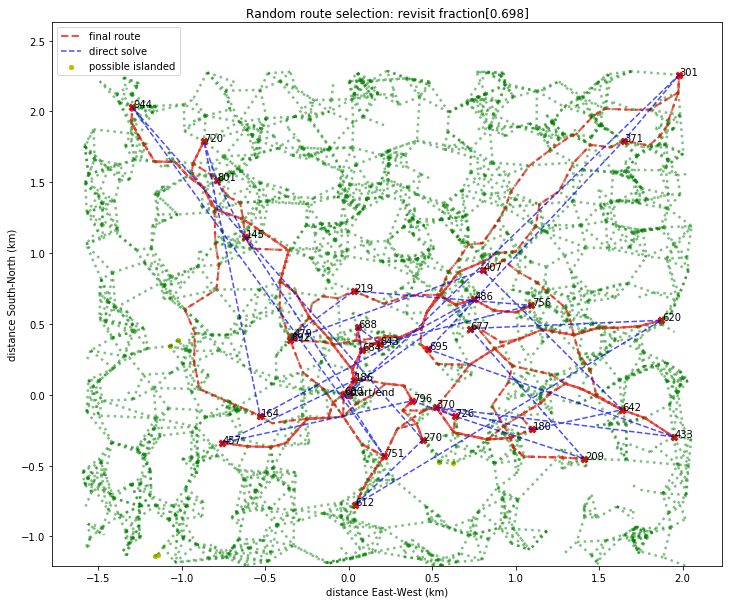

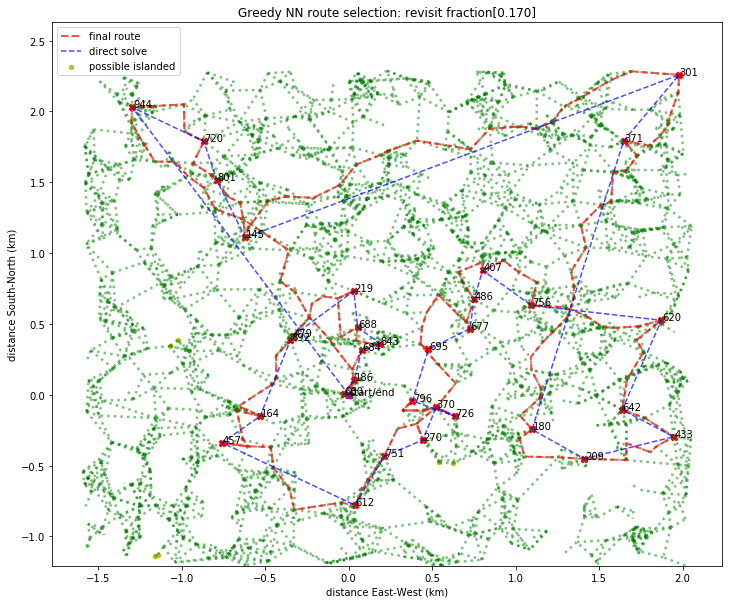

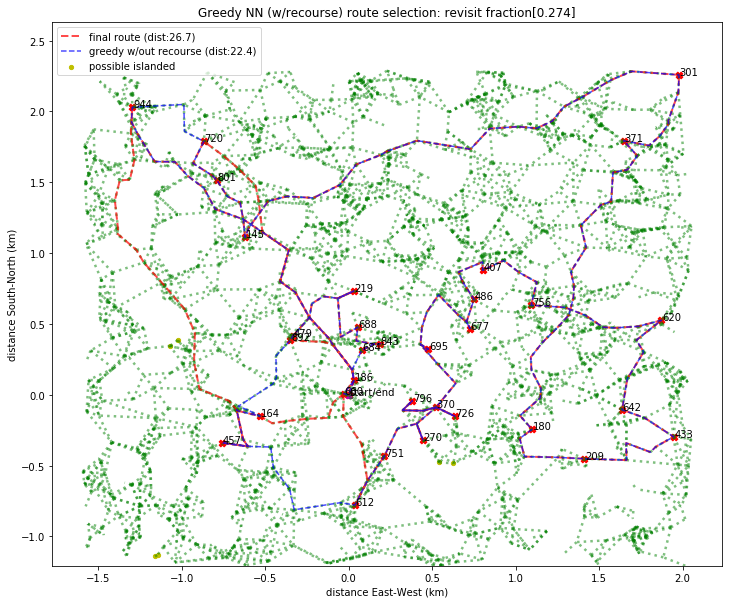

In [7]:
figsize=(12, 10)
plot_mail_route(random_route_expd, stop_locations, mail_stop_indices, walkways, xrange, 
                alt_route=random_route, 
                islanded=islanded, figsize=figsize,
                title=f'Random route selection: revisit fraction[{rand_revisit_frac:.3f}]')

plot_mail_route(tsp_optimized_route_expd, stop_locations, mail_stop_indices, walkways, xrange, 
                alt_route=tsp_optimized_route, #plot_node_labels=True,
                islanded=islanded, figsize=figsize,
                title=f'Greedy NN route selection: revisit fraction[{opt_revisit_frac:.3f}]')

plot_mail_route(tsp_opt_rec_route_expd, stop_locations, mail_stop_indices, walkways, xrange, 
                alt_route=tsp_optimized_route_expd, figsize=figsize,
                route_label=f'final route (dist:{total_distance(tsp_opt_rec_route_expd, walkways):.1f})',
                alt_route_label=f'greedy w/out recourse (dist:{total_distance(tsp_optimized_route_expd, walkways):.1f})',
                islanded=islanded, alt_route_color='b',
                title=f'Greedy NN (w/recourse) route selection: revisit fraction[{opt_rec_revisit_frac:.3f}]')

### Path update without solving TSP again
In this case, we have a few additional stops that we would like to integrate into our path planning. We can do this one of two different ways (in this limited scope). 
* resolve the TSP with the new points included in the solve
* attempt to update only the part of graph cycle that is nearest the new points, this is what the `quick_adjust_route()` solver attempts to do

As we see below, the `quick_adjust_route()` method requires a 10th of the runtime, while produces a solution close (slightly longer) that of NN TSP route solution

In [8]:
interesting_places_to_visit = [585, 696, 882, 63]

route_qu, subroutes_qu, expanded_route_qu, skip_points, valid = quick_adjust_route(
        tsp_optimized_route, tsp_opt_subroutes, 
        interesting_places_to_visit, dist_mat, walkways, debug=0)
qu_valid, qu_revisit_frac = check_valid_path(
    points, tsp_optimized_route_expd, walkways, '', allow_between_stops=True)
print(
    f"quick-update init distance:  {total_distance(route_qu, dist_mat):.3f} "
    f"[complete: {total_distance(expanded_route_qu, dist_mat):.3f}] "
    f"valid[{valid}] valid_expd[{qu_valid}] revisit_frac[{qu_revisit_frac:.3f}]")

route_qu_rec, subroutes_qu_rec, expanded_route_qu_rec, skip_points, valid_rec = quick_adjust_route(
        tsp_optimized_route, tsp_opt_subroutes, 
        interesting_places_to_visit, dist_mat, walkways, debug=0)
qu_rec_valid, qu_rec_revisit_frac = check_valid_path(
    points, tsp_optimized_route_expd, walkways, '', allow_between_stops=True)
print(
    f"quick-update init distance:  {total_distance(route_qu_rec, dist_mat):.3f} "
    f"[complete: {total_distance(expanded_route_qu_rec, dist_mat):.3f}] "
    f"valid[{valid_rec}] valid_expd[{qu_rec_valid}] revisit_frac[{qu_rec_revisit_frac:.3f}]")

quick-update init distance:  20.568 [complete: 26.078] valid[True] valid_expd[True] revisit_frac[0.170]
quick-update init distance:  20.568 [complete: 26.078] valid[True] valid_expd[True] revisit_frac[0.170]


<IPython.core.display.Javascript object>


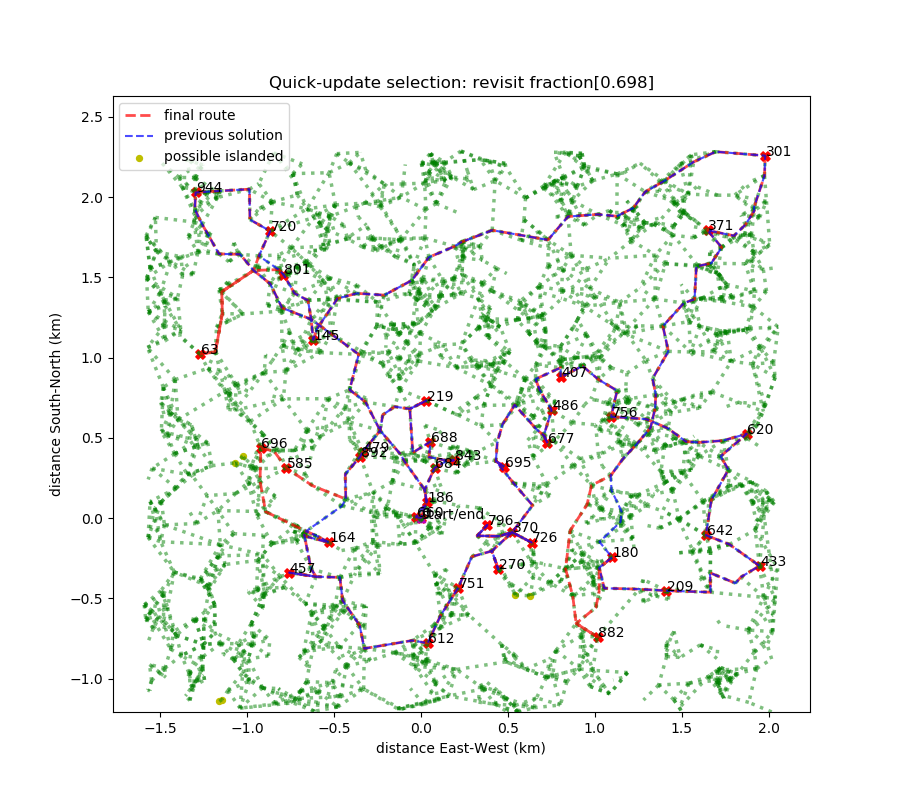

<IPython.core.display.Javascript object>


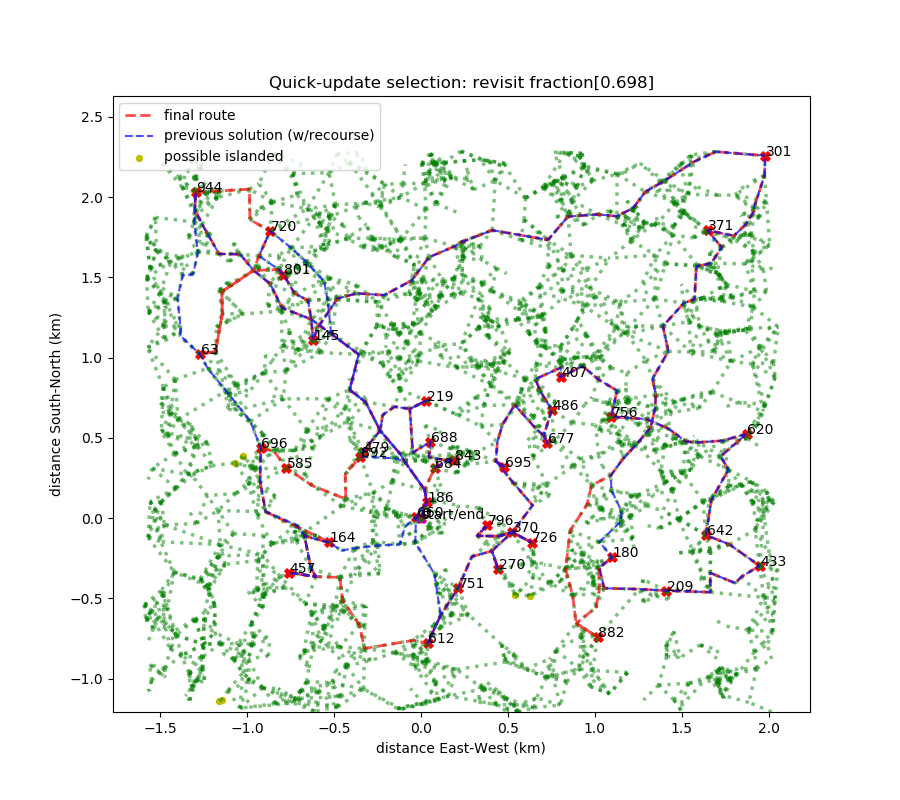

In [9]:
%matplotlib notebook
update_mailstops = mail_stop_indices
update_mailstops.extend(interesting_places_to_visit)

plot_mail_route(expanded_route_qu, stop_locations, update_mailstops, walkways, xrange, 
                alt_route=tsp_optimized_route_expd, alt_route_label='previous solution',
                islanded=islanded, alt_route_color='b',
                title=f'Quick-update selection: revisit fraction[{rand_revisit_frac:.3f}]')

plot_mail_route(expanded_route_qu_rec, stop_locations, update_mailstops, walkways, xrange, 
                alt_route=tsp_opt_rec_route_expd, alt_route_label='previous solution (w/recourse)',
                islanded=islanded, alt_route_color='b',
                title=f'Quick-update selection: revisit fraction[{rand_revisit_frac:.3f}]')